In [44]:
import os
import dotenv
import openai

In [45]:
dotenv.load_dotenv(verbose=True)
openai.api_key = os.getenv('OPENAI_API_KEY')

### preprocess medqa test.jsonl

In [14]:
import json

with open('./medqa/test.jsonl') as rf:
  contents = rf.read()

contents = contents.split('\n')
refined_contents = []

for content in contents:
  new_dict = dict()
  content_dict = json.loads(content)
  raw_question = content_dict['question'].strip()
  raw_options = content_dict['options']
  refined_options = '\n'.join([f'({k.strip()}) {v.strip()}' for k,v in raw_options.items()])
  
  full_question = 'Question : ' + raw_question + '\n' + refined_options 
  answer = '(' + content_dict['answer_idx'] + ')'

  new_dict['question'] = full_question
  new_dict['answer'] = answer

  refined_contents.append(new_dict)

print(refined_contents[0])
print(len(refined_contents))

{'question': 'Question : A junior orthopaedic surgery resident is completing a carpal tunnel repair with the department chairman as the attending physician. During the case, the resident inadvertently cuts a flexor tendon. The tendon is repaired without complication. The attending tells the resident that the patient will do fine, and there is no need to report this minor complication that will not harm the patient, as he does not want to make the patient worry unnecessarily. He tells the resident to leave this complication out of the operative report. Which of the following is the correct next action for the resident to take?\n(A) Disclose the error to the patient but leave it out of the operative report\n(B) Disclose the error to the patient and put it in the operative report\n(C) Tell the attending that he cannot fail to disclose this mistake\n(D) Report the physician to the ethics committee\n(E) Refuse to dictate the operative report', 'answer': '(C)'}
1273


### predict using gpt-3.5-turbo-instruct

In [54]:
# from openai import OpenAI

# client = OpenAI()
# prob_dict = dict()

# for idx, content in enumerate(refined_contents):
#   instruction = "Answer the following question to the best of your ability. You must answer the question with one of the valid choices. You must provide only a single answer.\n\n"
#   twoshot = "Question : This is a question\n(A) first answer\n(B) second answer\n(C) third answer\n(D) fourth answer\n(E) fifth answer\nAnswer : (D)\n\nQuestion : This is a question\n(A) first answer\n(B) second answer\n(C) third answer\n(D) fourth answer\n(E) fifth answer\nAnswer : (A)\n\n"
#   question = content['question']
#   answer_prompt = "\nAnswer :"

#   prompt = instruction + twoshot + question + answer_prompt

#   response = client.completions.create(
#     model="gpt-3.5-turbo-instruct",
#     prompt=prompt,
#     temperature=0,
#     max_tokens=400,
#     top_p=0.5,
#     frequency_penalty=0.1,
#     presence_penalty=0.1,
#     stop=["\nUser: "],
#     logprobs=5
#   )

#   probs = response.choices[0].logprobs
#   prob_dict[idx] = probs

In [75]:
# convert "logprobs" object to dict

prob_dict_refined = dict()

for k,v in prob_dict.items():
  value_dict = dict()
  
  text_offset = v.text_offset
  token_logprobs = v.token_logprobs
  tokens = v.tokens
  top_logprobs = v.top_logprobs
  
  value_dict["text_offset"] = text_offset
  value_dict["token_logprobs"] = token_logprobs
  value_dict["tokens"] = tokens
  value_dict["top_logprobs"] = top_logprobs
  
  prob_dict_refined[k] = value_dict


In [78]:
with open("gpt3-logprob-medqa.json", 'w') as wf:
  json.dump(prob_dict_refined, wf, indent=4)


### check accuracy

In [2]:
import json

with open("gpt3-logprob-medqa.json", 'r') as rf:
  results = json.load(rf)

testset = set()
testlist = []
for k, v in results.items():
  target_logprob = v['top_logprobs'][1] # A,B,C,D,E 별 log prob 결과 (0번째는 여는 괄호)
  testlist.append(str(target_logprob))

with open('logprob_for_answers.txt', 'w') as wf:
  wf.write('\n'.join(testlist))

In [10]:
pred_list = []
for k, v in results.items():
  target_logprob = v['top_logprobs'][1]
  pred = list(target_logprob.keys())[0]
  pred_list.append(pred)

In [13]:
print(pred_list)
print(len(pred_list))

['B', 'D', 'C', 'A', 'B', 'E', 'A', 'C', 'E', 'B', 'E', 'D', 'B', 'E', 'D', 'B', 'E', 'E', 'B', 'C', 'E', 'A', 'D', 'B', 'A', 'E', 'E', 'A', 'D', 'A', 'E', 'D', 'C', 'E', 'B', 'C', 'D', 'A', 'D', 'A', 'D', 'C', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'D', 'E', 'E', 'B', 'C', 'B', 'B', 'C', 'B', 'C', 'C', 'C', 'A', 'D', 'A', 'A', 'D', 'C', 'C', 'E', 'A', 'A', 'A', 'E', 'B', 'D', 'E', 'B', 'C', 'B', 'C', 'B', 'E', 'C', 'B', 'D', 'A', 'C', 'D', 'C', 'C', 'E', 'B', 'D', 'C', 'E', 'E', 'B', 'B', 'C', 'B', 'C', 'D', 'A', 'A', 'B', 'B', 'A', 'D', 'C', 'B', 'D', 'C', 'A', 'B', 'C', 'E', 'B', 'D', 'E', 'C', 'D', 'B', 'E', 'A', 'B', 'B', 'A', 'D', 'C', 'A', 'B', 'B', 'A', 'B', 'A', 'C', 'D', 'A', 'C', 'D', 'B', 'C', 'A', 'B', 'D', 'C', 'D', 'D', 'B', 'D', 'A', 'E', 'C', 'A', 'D', 'D', 'B', 'A', 'C', 'C', 'D', 'B', 'D', 'A', 'A', 'A', 'B', 'D', 'B', 'D', 'D', 'C', 'C', 'D', 'E', 'D', 'E', 'D', 'C', 'D', 'A', 'B', 'B', 'E', 'A', 'C', 'C', 'B', 'E', 'C', 'A', 'D', 'E', 'C', 'A', 'C', 'A', 'C', 'C', 'D',

In [17]:
answer_list = []
for content in refined_contents:
  answer = content['answer']
  answer = answer.lstrip('(')
  answer = answer.rstrip(')')
  answer_list.append(answer)

In [18]:
print(answer_list)
print(len(answer_list))

['C', 'E', 'C', 'D', 'B', 'E', 'D', 'C', 'C', 'A', 'E', 'D', 'B', 'E', 'D', 'B', 'E', 'E', 'B', 'E', 'C', 'A', 'D', 'E', 'A', 'E', 'E', 'A', 'D', 'D', 'E', 'C', 'E', 'B', 'B', 'A', 'E', 'A', 'E', 'A', 'D', 'C', 'A', 'C', 'B', 'E', 'C', 'A', 'B', 'D', 'E', 'A', 'D', 'D', 'B', 'B', 'C', 'B', 'C', 'A', 'D', 'A', 'D', 'A', 'A', 'C', 'D', 'C', 'D', 'A', 'A', 'A', 'C', 'B', 'C', 'A', 'B', 'B', 'D', 'C', 'B', 'B', 'C', 'B', 'D', 'C', 'C', 'D', 'C', 'C', 'E', 'B', 'D', 'E', 'C', 'D', 'A', 'B', 'C', 'C', 'E', 'A', 'A', 'A', 'C', 'B', 'C', 'A', 'E', 'C', 'D', 'C', 'B', 'D', 'D', 'E', 'D', 'D', 'E', 'C', 'D', 'B', 'E', 'A', 'B', 'A', 'A', 'D', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'C', 'D', 'E', 'C', 'D', 'D', 'A', 'A', 'B', 'D', 'D', 'D', 'D', 'B', 'E', 'A', 'E', 'A', 'A', 'D', 'E', 'B', 'A', 'D', 'C', 'D', 'B', 'D', 'A', 'A', 'B', 'B', 'D', 'B', 'D', 'C', 'D', 'C', 'A', 'E', 'D', 'E', 'D', 'D', 'D', 'B', 'E', 'B', 'E', 'B', 'D', 'C', 'B', 'E', 'C', 'A', 'D', 'E', 'C', 'C', 'C', 'A', 'C', 'E', 'D',

In [21]:
# accuracy

correct = 0
incorrect = 0
for a,b in zip(pred_list, answer_list):
  if a == b:
    correct += 1
  else:
    incorrect += 1

print(f'correct : {correct}, incorrect : {incorrect}')
print(f'accuracy : {correct / 1273}')

correct : 680, incorrect : 593
accuracy : 0.5341712490180676


### check AUROC (t=0.01 단위)

In [27]:
import math

target_prob = dict()
for k, v in results.items():
  prob_dict = dict()

  target_logprob = v['top_logprobs'][1]
  options = list(target_logprob.keys())
  
  # logprob -> prob for all options
  for option in options:
    logprob = target_logprob[option]
    prob = math.pow(math.e, logprob)
    prob_dict[option] = prob
  
  target_prob[k] = prob_dict

In [29]:
target_prob

{'0': {'B': 0.5432241472637939,
  'C': 0.41563066399821336,
  'A': 0.01957324297019489,
  'D': 0.013732439477538402,
  'E': 0.007633420026279691},
 '1': {'D': 0.27297982162239315,
  'C': 0.23818125965215095,
  'E': 0.21845572861718815,
  'B': 0.15622692207408706,
  'A': 0.11314541829879243},
 '2': {'C': 0.9833252378944318,
  'D': 0.006909926348102199,
  'B': 0.0042472354077578,
  'E': 0.002698095837890483,
  'A': 0.0026705415484547797},
 '3': {'A': 0.8012322691324261,
  'B': 0.13688448281102977,
  'D': 0.030046827428413834,
  'E': 0.020158637951317424,
  'C': 0.01087335910813712},
 '4': {'B': 0.9881219941465039,
  'D': 0.0104065038302792,
  'C': 0.0008425510534558565,
  'A': 0.0004490024112361615,
  'E': 8.966159768702243e-05},
 '5': {'E': 0.8342641000709377,
  'C': 0.1587886986330163,
  'B': 0.0055046009504492194,
  'D': 0.0006875115008873849,
  'A': 0.0006002393893922458},
 '6': {'A': 0.7693037453594361,
  'D': 0.14160940222964838,
  'B': 0.03964001464778937,
  'E': 0.028223892725232

In [49]:
# create [(pred, prob), answer] list

pairs_for_roc = []
for idx, probdict in target_prob.items():
  sublist = []
  
  # sort just in case
  sorted_probdict = sorted(probdict.items(), key=lambda x:x[1], reverse=True)
  pred_with_prob = sorted_probdict[0] # e.g. ('B', 0.5432241472637939)
  answer = answer_list[int(idx)] # variable from previous cell (accuracy)

  sublist.append(pred_with_prob)
  sublist.append(answer)

  pairs_for_roc.append(sublist)
  

In [96]:
print(pairs_for_roc[0])
print(len(pairs_for_roc))

[('B', 0.5432241472637939), 'C']
1273


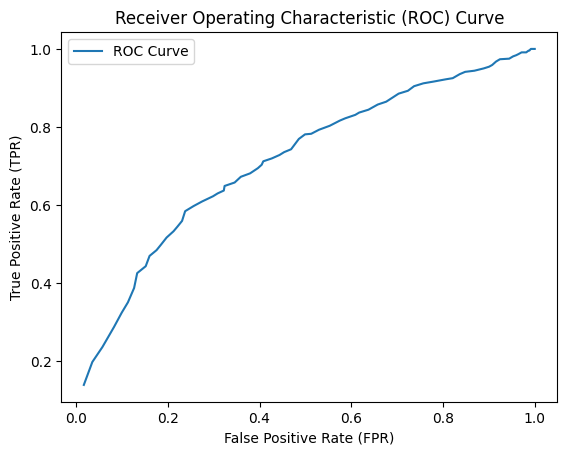

In [97]:
import numpy as np
import matplotlib.pyplot as plt

roc_points = []

for t in np.arange(0, 1, 0.01): # confidence threshold별로 iterate
    
  correct = 0
  incorrect = 0
  correct_above_t = 0
  incorrect_above_t = 0
  
  for pair in pairs_for_roc:

    pred = pair[0][0]
    prob = pair[0][1]
    answer = pair[1]

    # for TPR
    if pred == answer:
      correct += 1
      if prob >= t:
        correct_above_t += 1
    # for FPR
    elif pred != answer:
      incorrect += 1
      if prob >= t:
        incorrect_above_t += 1

  tpr = correct_above_t / correct
  fpr = incorrect_above_t / incorrect

  roc_points.append((tpr, fpr))

tpr_values, fpr_values = zip(*roc_points)

# plot roc curve
plt.plot(fpr_values, tpr_values, label='ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [98]:
import sklearn
from sklearn.metrics import auc  
xx = sorted(fpr_values)
yy = sorted(tpr_values)
auc(xx,yy)


0.7091843567106437

### AUC

In [114]:
import numpy as np

eps = 0.001 # small noise for top k% prediction
pairs_for_auc = [ [(pred, score+np.random.normal(0, eps)), answer] for (pred, score), answer in pairs_for_roc]

pairs_for_auc

[[('B', 0.5426545445071423), 'C'],
 [('D', 0.2742070881108511), 'E'],
 [('C', 0.9825357704366683), 'C'],
 [('A', 0.7998824957116906), 'D'],
 [('B', 0.9888513146740657), 'B'],
 [('E', 0.8328566482541986), 'E'],
 [('A', 0.7677620522270894), 'D'],
 [('C', 0.5556702122696909), 'C'],
 [('E', 0.7615296468730285), 'C'],
 [('B', 0.33407378284586714), 'A'],
 [('E', 0.7239010041117913), 'E'],
 [('D', 0.652096348418877), 'D'],
 [('B', 0.99423853475712), 'B'],
 [('E', 0.7541262215772021), 'E'],
 [('D', 0.5387610719193454), 'D'],
 [('B', 0.5994205333320599), 'B'],
 [('E', 0.9610732508418491), 'E'],
 [('E', 0.9183652727113865), 'E'],
 [('B', 0.6411815468537635), 'B'],
 [('C', 0.9869634830434492), 'E'],
 [('E', 0.7846219149788944), 'C'],
 [('A', 0.9199048978154661), 'A'],
 [('D', 0.6505522665422592), 'D'],
 [('B', 0.9657709610153093), 'E'],
 [('A', 0.9076536448833947), 'A'],
 [('E', 0.9918825306998685), 'E'],
 [('E', 0.8989808409267028), 'E'],
 [('A', 0.9957913940810117), 'A'],
 [('D', 0.658341198879

In [121]:
pairs_for_auc_sorted = sorted(pairs_for_auc, key=lambda x: x[0][1], reverse=True)
auc_points = []

for cov in np.arange(0, 1, 0.01):
  
  correct = 0
  num_eval = int(len(pairs_for_auc_sorted) * cov)
  pairs_to_evaluate = pairs_for_auc_sorted[:num_eval]
  total = len(pairs_to_evaluate)

  for pair in pairs_to_evaluate:
    pred = pair[0][0]
    answer = pair[1]

    if pred == answer:
      correct += 1
    
  acc = correct / total
  auc_points.append((cov, acc))


cov_values, acc_values = zip(*roc_points)

# plot roc curve
plt.plot(cov_values, acc_values, label='AUC Curve')
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.title('Area Under Coverage-accuracy (AUC) Curve')
plt.legend()
plt.show()


ZeroDivisionError: division by zero